In [1]:
from molmap import model as molmodel
import molmap
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

np.random.seed(123)
tf.compat.v1.set_random_seed(123)

#tmp_feature_dir = './tmpignore'
tmp_feature_dir = '/raid/shenwanxiang/tempignore'

if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)

In [2]:
mp1 = molmap.loadmap('../descriptor.mp')
mp2 = molmap.loadmap('../fingerprint.mp')

In [3]:
task_name = 'ChEMBL'
from chembench import load_data
df, induces = load_data(task_name)

loading dataset: ChEMBL number of split times: 3


In [4]:
print(len(induces[0][0]), len(induces[0][1]), len(induces[0][2]))

365047 45631 45631


## 22 compounds has no smiles

In [5]:
nan_idx = df[df.smiles.isna()].index.to_list()
nan_idx

[226200,
 379799,
 380656,
 381454,
 393024,
 393968,
 396794,
 397302,
 400352,
 402496,
 404107,
 406599,
 407755,
 408279,
 418481,
 419581,
 419589,
 419590,
 441931,
 442248,
 447060,
 453014]

In [6]:
MASK = -1
smiles_col = df.columns[0]
values_col = df.columns[1:]
Y = df[values_col].astype('float').fillna(MASK).values
if Y.shape[1] == 0:
    Y = Y.reshape(-1, 1)
    Y = Y.astype('float32')

In [7]:
Y.shape

(456331, 1310)

### batch extract features

In [8]:
batch = 30
xs = np.array_split(df.smiles.to_list(), batch)

In [9]:

X1_name_all = os.path.join(tmp_feature_dir, 'X1_%s.data' % (task_name))
X2_name_all = os.path.join(tmp_feature_dir, 'X2_%s.data' % (task_name))

if os.path.exists(X1_name_all) & os.path.exists(X2_name_all):
    X1 = load(X1_name_all)
    X2 = load(X2_name_all)
else:
    ## descriptors
    X1s = []
    for i, batch_smiles in tqdm(enumerate(xs), ascii=True):
        ii = str(i).zfill(2)
        X1_name = os.path.join(tmp_feature_dir, 'X1_%s_%s.data' % (task_name, ii))
        print('save to %s' % X1_name)
        if not os.path.exists(X1_name):
            X1 = mp1.batch_transform(batch_smiles, n_jobs = 8)
            X1 = X1.astype('float32')
            dump(X1, X1_name)
            
        else:
            X1 = load(X1_name)
        X1s.append(X1)
        del X1
        
    X1 = np.concatenate(X1s)
    del X1s
    
    dump(X1, X1_name_all)
    
    ## fingerprint
    X2s = []      
    for i, batch_smiles in tqdm(enumerate(xs), ascii=True):
        ii = str(i).zfill(2)
        X2_name = os.path.join(tmp_feature_dir, 'X2_%s_%s.data' % (task_name, ii))
        if not os.path.exists(X2_name):
            X2 = mp2.batch_transform(batch_smiles, n_jobs = 8)
            X2 = X2.astype('float32')
            dump(X2, X2_name)
            
        else:
            X2 = load(X2_name)
            
        X2s.append(X2)
        del X2
        
    X2 = np.concatenate(X2s)
    del X2s
    dump(X2, X2_name_all)

In [10]:
molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]
X1.shape

(456331, 37, 37, 13)

In [11]:
def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

prcs_metrics = ['MUV', 'PCBA']

In [12]:
epochs = 800
patience = 10 #early stopping, dual to large computation cost, the larger dataset  set small waitig patience for early stopping
dense_layers = [2048]  #1310 outputs

batch_size = 128
lr = 1e-4
weight_decay = 0

monitor = 'val_auc'
dense_avf = 'relu'
last_avf = None #sigmoid in loss

if task_name in prcs_metrics:
    metric = 'PRC'
else:
    metric = 'ROC'

In [13]:
results = []
for i, split_idxs in enumerate(induces):

    train_idx, valid_idx, test_idx = split_idxs
    
    print(len(train_idx), len(valid_idx), len(test_idx))
    
    train_idx = list(set(train_idx) - set(nan_idx))
    valid_idx = list(set(valid_idx) - set(nan_idx))
    test_idx = list(set(test_idx) - set(nan_idx))

    trainX = (X1[train_idx], X2[train_idx])
    trainY = Y[train_idx]

    validX = (X1[valid_idx], X2[valid_idx])
    validY = Y[valid_idx]

    testX = (X1[test_idx], X2[test_idx])
    testY = Y[test_idx]            

    pos_weights, neg_weights = get_pos_weights(trainY)
    loss = lambda y_true, y_pred: molmodel.loss.weighted_cross_entropy(y_true,y_pred, pos_weights, MASK = -1)

    model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                       n_outputs=Y.shape[-1], 
                                       dense_layers=dense_layers, 
                                       dense_avf = dense_avf, 
                                       last_avf=last_avf)

    opt = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
    #import tensorflow_addons as tfa
    #opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = loss)

    performance = molmodel.cbks.CLA_EarlyStoppingAndPerformance((trainX, trainY), 
                                                                   (validX, validY), 
                                                                   patience = patience, 
                                                                   criteria = monitor,
                                                                   metric = metric,
                                                                  )
    model.fit(trainX, trainY, batch_size=batch_size, 
          epochs=epochs, verbose= 0, shuffle = True, 
          validation_data = (validX, validY), 
          callbacks=[performance]) 


    best_epoch = performance.best_epoch
    trainable_params = model.count_params()
    
    train_aucs = performance.evaluate(trainX, trainY)            
    valid_aucs = performance.evaluate(validX, validY)            
    test_aucs = performance.evaluate(testX, testY)

    final_res = {
                     'task_name':task_name,            
                     'train_auc':np.nanmean(train_aucs), 
                     'valid_auc':np.nanmean(valid_aucs),                      
                     'test_auc':np.nanmean(test_aucs), 
                     'metric':metric,
                     '# trainable params': trainable_params,
                     'best_epoch': best_epoch,
                     'batch_size':batch_size,
                     'lr': lr,
                     'weight_decay':weight_decay
                    }
    
    results.append(final_res)

365047 45631 45631
epoch: 0001, loss: 0.6953 - val_loss: 0.6948; auc: 0.6349 - val_auc: 0.6179                                                                                                    
epoch: 0002, loss: 0.6944 - val_loss: 0.6944; auc: 0.6898 - val_auc: 0.6903                                                                                                    
epoch: 0003, loss: 0.6939 - val_loss: 0.6942; auc: 0.7209 - val_auc: 0.7077                                                                                                    
epoch: 0004, loss: 0.6934 - val_loss: 0.6939; auc: 0.7386 - val_auc: 0.7166                                                                                                    
epoch: 0005, loss: 0.6931 - val_loss: 0.6939; auc: 0.7649 - val_auc: 0.7240                                                                                                    
epoch: 0006, loss: 0.6929 - val_loss: 0.6936; auc: 0.7747 - val_auc: 0.7250                          

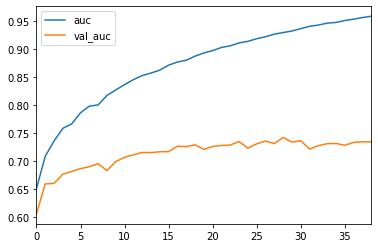

In [14]:
pd.DataFrame(performance.history)[['auc', 'val_auc']].plot()

In [15]:
pd.DataFrame(results)

,task_name,train_auc,valid_auc,test_auc,metric,# trainable params,best_epoch,batch_size,lr,weight_decay
0,ChEMBL,0.907848,0.764787,0.760440,ROC,4140734,22,128,0.0001,0
1,ChEMBL,0.891207,0.766938,0.745258,ROC,4140734,19,128,0.0001,0
2,ChEMBL,0.929407,0.742331,0.745781,ROC,4140734,28,128,0.0001,0


In [16]:
pd.DataFrame(results).test_auc.std()

0.008618132842095953

In [17]:
pd.DataFrame(results).test_auc.mean()

0.7504929158022563

In [18]:
pd.DataFrame(results).to_csv('./results/%s.csv' % task_name)